In [1]:
!pip3 install yfinance
!pip3 install pandas==1.5.3
!pip3 install pandas_ta
!pip3 install pandas_datareader
!pip3 install statsmodels
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install PyPortfolioOpt
!pip3 install jupyterlab
!pip3 install arch
!pip3 install pandas_datareader
!pip3 install alpaca-py


  Obtaining dependency information for pandas==1.5.3 from https://files.pythonhosted.org/packages/b0/be/1843b9aff84b98899663e7cad9f45513dfdd11d69cb5bd85c648aaf6a8d4/pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl (10.8 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3


# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.
* Video at: https://youtu.be/9Y3yaoi9rUQ?si=JnKro_HeAoDGfiht
* Source at: https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [2]:
from statsmodels.regression.rolling import RollingOLS
from datetime import datetime, timedelta
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import requests
import csv
import warnings
warnings.filterwarnings('ignore')

### Download tickers from Nasdaq

In [3]:
API_KEY = 'PKAFE6FQ1ZTHK0KNPDBU'
API_SECRET = 'x6DmwTMWv4Bfbdu9TyCxpV0hNTzIqGmSEtrazsrR'

from alpaca.data import StockHistoricalDataClient
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass, AssetStatus
from enum import Enum

class Market(Enum):
    """Enum for different market exchanges"""
    NASDAQ = "NASDAQ"
    NYSE = "NYSE"
    AMEX = "AMEX"
    ARCA = "ARCA"
    BATS = "BATS"
    IEX = "IEX"
    ALL = "ALL"

def get_tradable_tickers(api_key, api_secret, market=Market.ALL):
    """
    Retrieves a list of tradable stock tickers from Alpaca Markets
    
    Args:
        api_key (str): Your Alpaca API key
        api_secret (str): Your Alpaca API secret
        market (Market): The specific market to filter for (default: ALL)
        
    Returns:
        list: List of tradable stock symbols
    """
    try:
        # Initialize the trading client
        trading_client = TradingClient(api_key, api_secret)
        
        # Set up the request parameters
        search_params = GetAssetsRequest(
            asset_class=AssetClass.US_EQUITY,
            status=AssetStatus.ACTIVE
        )
        
        # Get all assets
        assets = trading_client.get_all_assets(search_params)
        
        # Filter for tradable assets and specified market
        tradable_tickers = []
        for asset in assets:
            if not asset.tradable:
                continue
                
            if market == Market.ALL:
                tradable_tickers.append({
                    'symbol': asset.symbol,
                    'exchange': asset.exchange
                })
            elif asset.exchange == market.value:
                tradable_tickers.append({
                    'symbol': asset.symbol,
                    'exchange': asset.exchange
                })
        
        # Sort by symbol
        tradable_tickers = sorted(tradable_tickers, key=lambda x: x['symbol'])
        
        return tradable_tickers
    
    except Exception as e:
        print(f"Error fetching tickers: {str(e)}")
        return []

def print_market_summary(tickers):
    """
    Prints a summary of tickers by exchange
    
    Args:
        tickers (list): List of ticker dictionaries
    """
    exchange_count = {}
    for ticker in tickers:
        exchange = ticker['exchange']
        exchange_count[exchange] = exchange_count.get(exchange, 0) + 1
    
    print("\nMarket Summary:")
    for exchange, count in sorted(exchange_count.items()):
        print(f"{exchange}: {count} tickers")

# Example usage

    
# Get all NASDAQ tickers
nasdaq_tickers = get_tradable_tickers(API_KEY, API_SECRET, Market.NASDAQ)
# print(f"\nFound {len(nasdaq_tickers)} NASDAQ tickers")
# print("First 5 NASDAQ tickers:")
# for ticker in nasdaq_tickers[:5]:
#     print(f"Symbol: {ticker['symbol']}, Exchange: {ticker['exchange']}")
    
# create a list symbols_list with all the nasdaq tickers
symbols_list = []
for ticker in nasdaq_tickers:
    symbols_list.append(ticker['symbol'])
    
symbols_list    

# Get all tickers across exchanges
# all_tickers = get_tradable_tickers(API_KEY, API_SECRET, Market.ALL)
# print(f"\nFound {len(all_tickers)} total tickers")
# print_market_summary(all_tickers)
# all_tickers

['AACG',
 'AADI',
 'AADR',
 'AAL',
 'AAME',
 'AAOI',
 'AAON',
 'AAPB',
 'AAPD',
 'AAPL',
 'AAPU',
 'AAXJ',
 'ABAT',
 'ABCL',
 'ABCS',
 'ABEO',
 'ABL',
 'ABLLL',
 'ABLLW',
 'ABLVW',
 'ABNB',
 'ABOS',
 'ABP',
 'ABPWW',
 'ABSI',
 'ABTS',
 'ABUS',
 'ABVC',
 'ABVE',
 'ABVEW',
 'ABVX',
 'ACAD',
 'ACB',
 'ACCD',
 'ACDC',
 'ACET',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACHC',
 'ACHL',
 'ACHV',
 'ACIC',
 'ACIU',
 'ACIW',
 'ACLS',
 'ACLX',
 'ACMR',
 'ACNB',
 'ACNT',
 'ACOG',
 'ACON',
 'ACONW',
 'ACRS',
 'ACRV',
 'ACT',
 'ACTG',
 'ACTU',
 'ACVA',
 'ACWI',
 'ACWX',
 'ACXP',
 'ADAG',
 'ADAP',
 'ADBE',
 'ADD',
 'ADEA',
 'ADGM',
 'ADI',
 'ADIL',
 'ADMA',
 'ADN',
 'ADNWW',
 'ADP',
 'ADPT',
 'ADSE',
 'ADSEW',
 'ADSK',
 'ADTN',
 'ADTX',
 'ADUR',
 'ADUS',
 'ADV',
 'ADVM',
 'ADVWW',
 'ADXN',
 'AEHL',
 'AEHR',
 'AEI',
 'AEIS',
 'AEMD',
 'AENT',
 'AENTW',
 'AEP',
 'AERT',
 'AERTW',
 'AEYE',
 'AFBI',
 'AFCG',
 'AFJK',
 'AFJKR',
 'AFJKU',
 'AFMD',
 'AFRI',
 'AFRIW',
 'AFRM',
 'AFYA',
 'AGAE',
 'AGEN',
 'AGFY',
 'AGIO

### Download tickers from S&P500

In [4]:
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# symbols_list = sp500['Symbol'].unique().tolist()

# # see https://fingpt.bot/ for stock prediction
# additional_symbols = ['ASML', 'VICI', 'WST','WYNN','ZBH','ABNB','AMZN','FTNT','GEHC','MRVL']
# # je bent heiiiiiir
# COMBINED_LIST = symbols_list + additional_symbols
# # remove double entries
# symbols_list = list(set(COMBINED_LIST))

# print(symbols_list)

### Download tickers from S&P500

### Download tickers from Nasdaq 

In [5]:
# def get_nasdaq_tickers(no_tickers=3000):
#     url = 'https://api.nasdaq.com/api/screener/stocks?tableonly=true&limit=25&offset=0&download=true'

#     headers = {
#             'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
#             }

#     resp = requests.get(url,headers=headers)
#     json_data = resp.json()
#     df = pd.DataFrame(json_data['data']['rows'],columns=json_data['data']['headers'])

#     ## convert columns to the correct data types
#     # df['lastsale'] = df['lastsale'].astype(float)

#     ## convert lastsale remove $ and convert to float
#     df['lastsale'] = df['lastsale'].str.replace('$','').astype(float)
#     ## convert netchange into float
#     df['netchange'] = df['netchange'].str.replace('$','').astype(float)
#     # convert pctchange remove % and convert to float
#     df['pctchange'] = pd.to_numeric(df['pctchange'].str.replace('%', ''), errors='coerce')
#     ## convert marketCap to string to float
#     df['marketCap'] = pd.to_numeric(df['marketCap'], errors='coerce')
#     ## convert volume to int
#     df['volume'] = df['volume'].str.replace(',','').astype(int)

#     df.to_csv('nasdaq.csv',index=False)

#     ### Select top 50 stocks with the highigest trade volume.

#     # Filter df and select the 100 rows with the highest volume
#     # df = df.sort_values('volume',ascending=False).head(no_tickers)
    
#    # hier moet je beter gaan filteren en de meest kansrijke aandelen selecteren

#     # tickers contains a list of df symbol and name 
#     tickers = list(df[['symbol','name']].itertuples(index=False, name=None))
#     # take tickers and copy the column symbol to a list
#     tickers = list(df['symbol'])
    

#     return tickers, df

# tickers, df = get_nasdaq_tickers(100)
# print(tickers)

## 1. Download/Load  stocks prices data.

In [4]:
# end_date = '2023-09-27'
# # end_date = '2024-05-1'

# start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Calculate the date 8 years ago from today 8*365
end_date = datetime.now()
start_date = end_date - timedelta(days=8*365)  # Approximation, does not account for leap years

# Format the dates in a way that yfinance expects
start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')


df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.to_csv('downloaded_stocks.csv')

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  4762 of 4762 completed

2495 Failed downloads:
['MRNOW', 'ILLRW', 'CCIXW', 'MLECW', 'FATBW', 'HYMCW', 'SBCWW', 'ZOOZW', 'AFRIW', 'BTBDW', 'DISTR', 'MCAGR', 'MKDWW', 'MTEKW', 'RVSNW', 'WINVR', 'ISRLW', 'NMHIW', 'GIGGW', 'SOUNW', 'CIFRW', 'DHCNL', 'CORZZ', 'CURIW', 'ATMCR', 'NXPLW', 'UKOMW', 'SXTPW', 'BEATW', 'GGROW', 'NXLIW', 'PEPS', 'CSLMW', 'VGASW', 'BETRW', 'SVIIW', 'NWTNW', 'HOFVW', 'KTTAW', 'TOIIW', 'BKHAR', 'DUETW', 'OABIW', 'WAVSW', 'RELIW', 'IROHR', 'WLDSW', 'IVCPW', 'FGIWW', 'NVVEW', 'AVPTW', 'ENGNW', 'CTCXW', 'EMCGR', 'USGOW', 'NIXXW', 'MSSAR', 'YHNAR', 'ZAPPW', 'NNAVW', 'FOXXW', 'BDMDW', 'GOVXW', 'KWESW', 'GPATW', 'BLACR', 'ABVEW', 'NCPLW', 'KVACW', 'CLNNW', 'RZLVW', 'KPLTW', 'OPTXW', 'RGTIW', 'KACLW', 'TSMU', 'BCGWW', 'CPTNW', 'GRRRW', 'SHOTW', 'DHAIW', 'APCXW', 'BRACR', 'EDBLW', 'ANGHW', 'MDCX', 'TMTCR', 'SNAXW', 'ATMCW', 'CXAIW', 'HUBCW', 'SBFMW', 'CSLMR', 'SHMDW', 'VACHW', 'NRSNW', 'DYCQR', 'CDIOW', 'BNIXR', 'NESRW', 'CR

Price                              adj close       close        high  \
date                      ticker                                       
2016-11-21 00:00:00+00:00 AACG      0.376918    3.930000    4.140000   
                          AADR     36.683411   40.160000   40.160000   
                          AAL      44.528633   46.080002   46.750000   
                          AAOI     26.209999   26.209999   27.280001   
                          AAPL     25.868608   27.932501   27.997499   
...                                      ...         ...         ...   
2024-11-15 00:00:00+00:00 ZM       81.139999   81.139999   81.980003   
                          ZNTL      3.470000    3.470000    4.000000   
                          ZS      201.470001  201.470001  205.535004   
                          ZTEK      1.260000    1.260000    1.290000   
                          ZVSA      1.080000    1.080000    1.140000   

Price                                    low        open       volume  
date                      ticker                                       
2016-11-21 00:00:00+00:00 AACG      3.900000    4.130000       3000.0  
                          AADR     40.020000   40.080002       8900.0  
                          AAL      45.950001   46.459999    6651400.0  
                          AAOI     25.540001   26.900000     301500.0  
                          AAPL     27.502501   27.530001  117058400.0  
...                                      ...         ...          ...  
2024-11-15 00:00:00+00:00 ZM       80.919998   81.519997    2234600.0  
                          ZNTL      3.360000    3.990000    1832100.0  
                          ZS      198.330002  204.669998    1346900.0  
                          ZTEK      0.960000    0.960000     308300.0  
                          ZVSA      1.040000    1.120000     115600.0  

[3066108 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [ ]:
# Filter out tickers with fewer than 20 rows of data so that we can calculate the 20-day moving average
df_filtered = df.groupby('ticker').filter(lambda x: len(x) >= 20)

# Ensure the DataFrame `df` retains the same format
df = df_filtered

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                        
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                        
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
   
    # # if len(close) < 25:
    # #     print("Not enough data to compute MACD")
    # #     return None
    # macd = pandas_ta.macd(close=close, length=20)
    # print ('Macd - ',macd.info())
    # macd = macd.iloc[:,0]
    # return macd.sub(macd.mean()).div(macd.std())


    if close.size < 25:  # Ensure there are enough data points for MACD calculation
        return pd.Series([None] * len(close), index=close.index)

    macd = pandas_ta.macd(close=close, length=20)
    if macd is None or macd.empty:
        print("Debug: MACD calculation returned None or empty for data:", close)
        return pd.Series([None] * len(close), index=close.index)
    macd_series = macd.iloc[:, 0]  # Assuming the first column is the MACD line
    return macd_series.sub(macd_series.mean()).div(macd_series.std())


df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

print(df)

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [8]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]


data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()



data

dollar_volume  adj close       atr   bb_high    bb_low  \
date       ticker                                                           
2017-01-31 AACG         0.001936   0.291560  0.010902  0.329314  0.228281   
           AAL        333.617378  42.760242  1.405724  3.891346  3.789143   
           AAOI        20.911874  30.760000  0.314894  3.632968  3.078426   
           AAON         4.282843  21.544376 -1.089785  3.146350  3.050841   
           AAXJ        54.780571  51.503437 -1.534773  3.972497  3.904120   
...                          ...        ...       ...       ...       ...   
2024-11-30 PC           0.096676   0.728000 -1.586890  1.331053  0.017710   
           SWP          0.171670  25.625999  1.527248  3.303812  3.248904   
           IBG          1.431422   1.050000 -0.523816  0.674970  0.407030   
           MYCG         0.010798  24.754999 -1.783290  3.254269  3.246061   
           VACH         0.505289  10.030000  0.183444  2.402987  2.397587   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2017-01-31 AACG    0.278797     -2.111108e+00 -0.168081  36.953928  
           AAL     3.840245     -5.223702e-04 -0.226348  41.153769  
           AAOI    3.355697      1.094302e-03   1.19671  61.505037  
           AAON    3.098596     -4.627625e-04 -0.109534  54.517211  
           AAXJ    3.938308     -6.842698e-03  0.673597  69.559143  
...                     ...               ...       ...        ...  
2024-11-30 PC      0.674381      1.319399e-03  1.224218  33.895511  
           SWP     3.276358      7.285000e-06 -0.792544  56.058307  
           IBG     0.541000      2.577135e-02   1.18264  33.451270  
           MYCG    3.250165      4.638078e-09  0.707107  39.726320  
           VACH    2.400287      1.131229e-07 -0.707107  57.556128  

[202482 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [9]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 AAL      50.711884  0.146087  3.972856  3.884601  3.928729   
           AAOI     37.820000  0.574502  3.797330  3.639503  3.718417   
           AAXJ     67.987373 -0.817501  4.234199  4.187777  4.210988   
           ACAD     30.110001 -0.330287  3.474793  3.365347  3.420070   
           ACWI     63.681858 -1.222005  4.175556  4.143771  4.159663   
...                       ...       ...       ...       ...       ...   
2024-11-30 DJT      28.100000  0.626803  3.875594  3.243027  3.559310   
           CEG     224.279999  1.988826  5.654832  5.374918  5.514875   
           NVDL     76.680000  1.173345  4.480709  4.248410  4.364559   
           GEHC     81.760002  0.323626  4.522190  4.424837  4.473513   
           ARM     128.729996  0.091097  5.072566  4.878231  4.975399   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-12-31 AAL            -0.000305  1.392049  59.214284  
           AAOI            0.000614  -0.75039  38.765691  
           AAXJ           -0.005399  0.229295  59.578327  
           ACAD            0.000197  0.023633  49.453103  
           ACWI           -0.006331  0.228781  65.806277  
...                             ...       ...        ...  
2024-11-30 DJT             0.002036  0.161377  48.752326  
           CEG             0.000365 -2.133406  40.407952  
           NVDL            0.002009  1.074521  53.769776  
           GEHC            0.000062 -1.273149  34.862021  
           ARM             0.000801 -0.814395  41.179725  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [10]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-12-31 AAL      31.599047  1.668478  3.675254  3.378042  3.526648   
           AAOI     15.430000  0.102532  3.183254  2.632655  2.907955   
           AAXJ     57.765343  0.502995  4.118787  4.045044  4.081915   
           ACWI     57.870953  0.665857  4.162809  4.027364  4.095087   
           ADI      77.079361 -0.501335  4.442982  4.297047  4.370014   
...                       ...       ...       ...       ...       ...   
2024-11-30 UPST     68.360001 -0.210889  4.376145  3.726263  4.051204   
           AFRM     56.150002 -0.018868  4.089827  3.647078  3.868452   
           HOOD     32.320000  0.661637  3.576991  3.175760  3.376376   
           DJT      28.100000  0.626803  3.875594  3.243027  3.559310   
           CEG     224.279999  1.988826  5.654832  5.374918  5.514875   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-12-31 AAL             0.000336 -1.471682  43.366388  -0.200448   
           AAOI            0.002680 -1.047676  36.121610  -0.250607   
           AAXJ           -0.004226 -0.488017  47.697574  -0.034629   
           ACWI           -0.004038 -1.671438  41.372167  -0.072101   
           ADI            -0.004554 -0.646278  48.397140  -0.066253   
...                             ...       ...        ...        ...   
2024-11-30 UPST            0.002794  0.658437  64.226843   0.404273   
           AFRM            0.004365  0.913447  63.888304   0.280502   
           HOOD            0.000557  2.182311  66.666448   0.375905   
           DJT             0.002036  0.161377  48.752326  -0.204867   
           CEG             0.000365 -2.133406  40.407952  -0.138997   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAL     -0.041948  -0.079853  -0.026639  -0.051263   -0.038653  
           AAOI    -0.113410  -0.144689  -0.163075  -0.052458   -0.071988  
           AAXJ     0.011584  -0.029930  -0.017522  -0.019713   -0.013402  
           ACWI    -0.029118  -0.044430  -0.015403  -0.009979   -0.007942  
           ADI      0.015307  -0.022749  -0.016688  -0.004991   -0.001376  
...                      ...        ...        ...        ...         ...  
2024-11-30 UPST     0.307124   0.171667   0.184747   0.114587    0.081292  
           AFRM     0.172839   0.084591   0.114691   0.045813    0.041651  
           HOOD     0.174741   0.171155   0.075361   0.078952    0.112393  
           DJT      0.322346   0.129511  -0.088789   0.093597    0.059463  
           CEG     -0.070039   0.045255   0.007565   0.033937    0.053427  

[10010 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [11]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAL    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.200448
           AAOI   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.250607
           AAXJ   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.034629
           ACWI   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.072101
           ADI    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.066253
...                   ...     ...     ...     ...     ...        ...
2024-09-30 WDAY    0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.071355
           WDC     0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.041165
           ZI      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.043478
           ZM      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.009554
           ZS      0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.145214

[9726 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [12]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAL    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.200448
           AAOI   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.250607
           AAXJ   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.034629
           ACWI   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.072101
           ADI    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.066253
...                   ...     ...     ...     ...     ...        ...
2024-09-30 WDAY    0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.071355
           WDC     0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.041165
           ZI      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.043478
           ZM      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.009554
           ZS      0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.145214

[9673 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [13]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAOI         NaN       NaN       NaN       NaN       NaN
           AAXJ         NaN       NaN       NaN       NaN       NaN
           ACWI         NaN       NaN       NaN       NaN       NaN
           ADI          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-09-30 WDAY    1.092285 -0.889750 -0.080871 -1.746408  0.018643
           WDC     1.500478 -0.860028  1.176068 -1.204287 -2.085514
           ZI      0.336675  0.411844 -1.188896 -4.833845  2.525082
           ZM      0.954657  0.393379  0.050203 -1.270801 -0.398327
           ZS      0.632370 -0.845385  1.486322 -2.698773 -4.029898

[9673 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [14]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9440 entries, (Timestamp('2018-12-31 00:00:00'), 'AAL') to (Timestamp('2024-11-30 00:00:00'), 'LI')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               9440 non-null   float64
 1   bb_high           9440 non-null   float64
 2   bb_low            9440 non-null   float64
 3   bb_mid            9440 non-null   float64
 4   garman_klass_vol  9440 non-null   float64
 5   macd              9440 non-null   object 
 6   rsi               9440 non-null   float64
 7   return_1m         9440 non-null   float64
 8   return_2m         9440 non-null   float64
 9   return_3m         9440 non-null   float64
 10  return_6m         9440 non-null   float64
 11  return_9m         9440 non-null   float64
 12  return_12m        9440 non-null   float64
 13  Mkt-RF            9440 non-null   float64
 14  SMB               9440 non-null   float64
 15  HML          

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

### Apply pre-defined centroids.

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
from sklearn.cluster import KMeans

if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-12-31 AAL     1.668478  3.675254  3.378042  3.526648          0.000336   
           ACWI    0.665857  4.162809  4.027364  4.095087         -0.004038   
           ADI    -0.501335  4.442982  4.297047  4.370014         -0.004554   
           ADP     0.421023  4.889201  4.689663  4.789432         -0.004845   
           ADSK    0.061793  4.999130  4.776604  4.887867          0.000156   
...                     ...       ...       ...       ...               ...   
2024-11-30 DDOG   -0.230607  4.883164  4.804325  4.843744          0.000455   
           PTON   -0.798198  2.360459  1.861208  2.110834          0.001056   
           BNTX   -0.340741  4.771759  4.642990  4.707374          0.002808   
           ZI     -1.149614  2.615622  2.367523  2.491572          0.001053   
           LI     -0.608997  3.436219  3.109772  3.272995          0.000133   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-12-31 AAL    -1.471682  43.366388  -0.200448  -0.041948  -0.079853   
           ACWI   -1.671438  41.372167  -0.072101  -0.029118  -0.044430   
           ADI    -0.646278  48.397140  -0.066253   0.015307  -0.022749   
           ADP    -1.479788  42.760618  -0.105505  -0.043323  -0.043440   
           ADSK   -0.778093  46.881282  -0.109965  -0.002479  -0.062550   
...                     ...        ...        ...        ...        ...   
2024-11-30 DDOG    0.225164  52.586409   0.005182   0.046835   0.027425   
           PTON    0.263532  60.325979  -0.088235   0.286850   0.184782   
           BNTX     -0.3449  39.209267  -0.118302  -0.083700   0.041690   
           ZI      0.319861  45.364096  -0.074208  -0.004370   0.011330   
           LI     -0.634641  44.120790  -0.091563  -0.058846   0.052984   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAL     -0.026639  -0.051263   -0.038653  1.207756  1.544064   
           ACWI    -0.015403  -0.009979   -0.007942  0.898106 -0.003211   
           ADI     -0.016688  -0.004991   -0.001376  0.884157  0.629135   
           ADP     -0.002064   0.017931    0.011167  0.602148  0.368779   
           ADSK    -0.003178   0.002653    0.017183  1.421668 -0.114432   
...                      ...        ...         ...       ...       ...   
2024-11-30 DDOG     0.022735  -0.004623    0.006563  0.974297 -0.256202   
           PTON     0.134227   0.059158    0.026535  2.887119  2.543232   
           BNTX    -0.001463   0.012767   -0.000574  0.942790  0.223710   
           ZI      -0.029983  -0.053375   -0.027921  0.627576  0.519311   
           LI       0.019367  -0.075116   -0.039716  1.452391  3.193275   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAL     0.287249  0.192087  0.758721        1  
           ACWI    0.000256  0.069697  0.109997        1  
           ADI     0.135807  0.443262 -0.349100        1  
           ADP     0.039490  0.608726 -0.282332        1  
           ADSK    0.439439 -0.400549 -1.016834        1  
...                     ...       ...       ...      ...  
2024-11-30 DDOG   -0.023454 -2.725318 -1.089340        2  
           PTON   -0.557800 -0.294871  1.064109        2  
           BNTX    0.575274  1.448120 -0.731370        1  
           ZI     -1.126377 -4.378844  2.204239        1  
           LI     -4.575488  1.089710  1.699509        1  

[9440 rows x 19 columns]

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


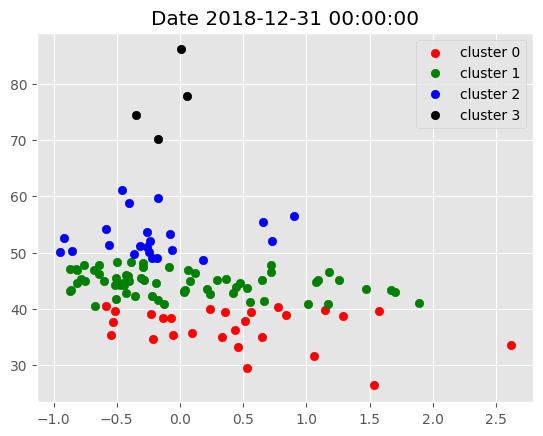

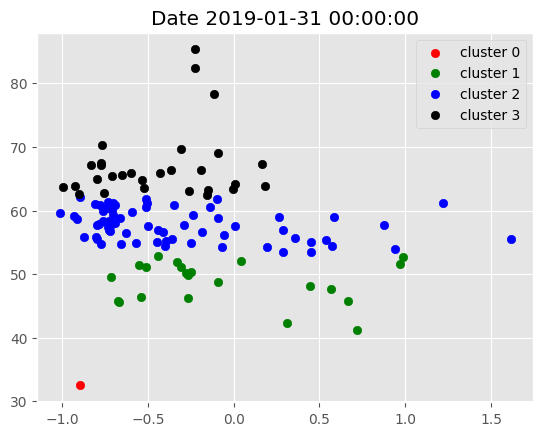

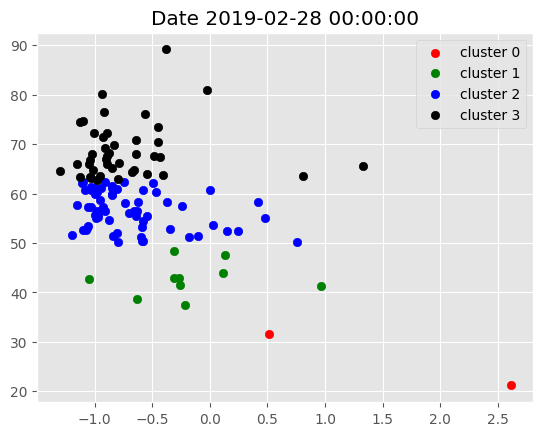

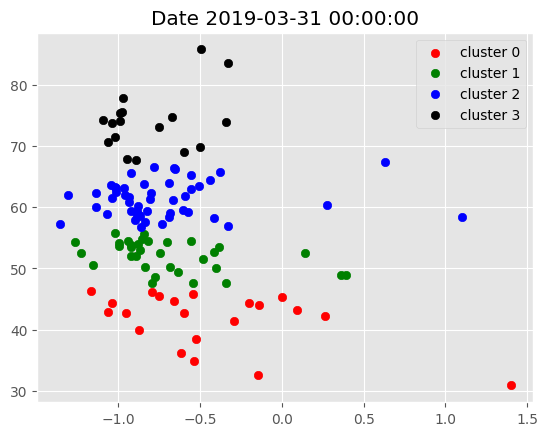

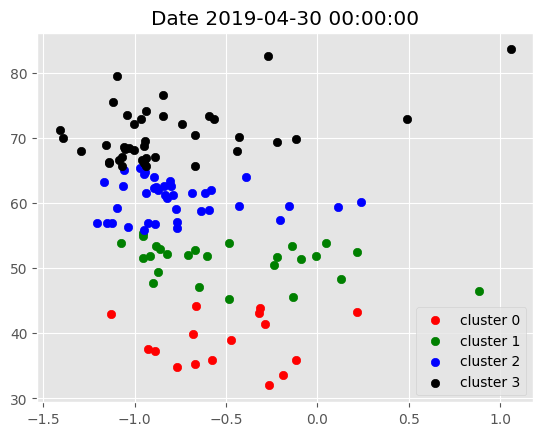

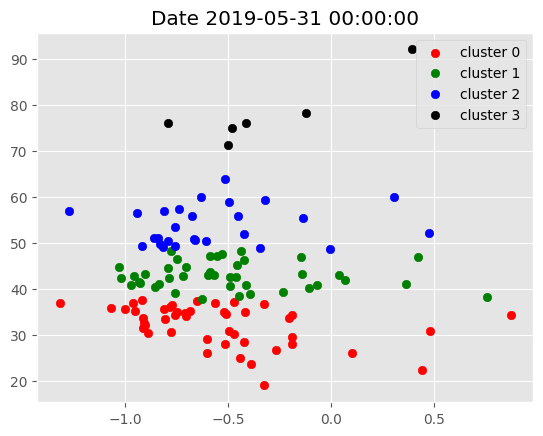

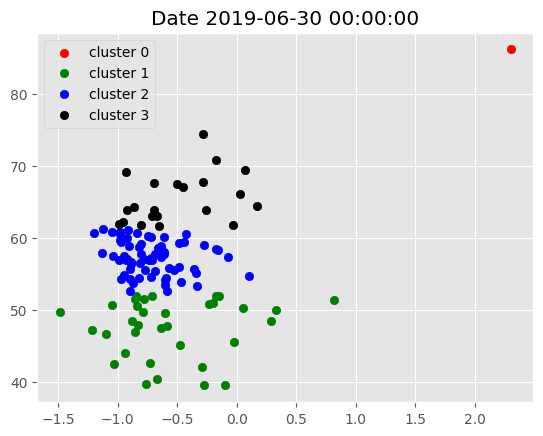

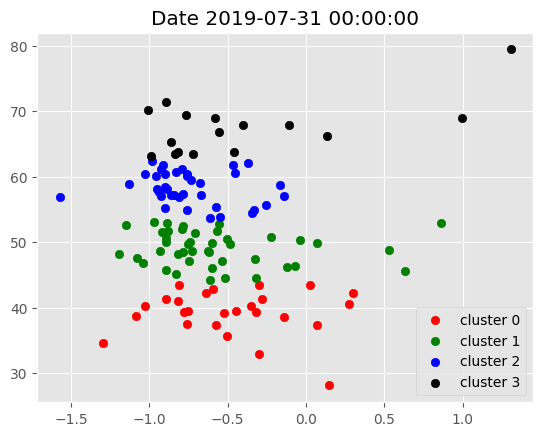

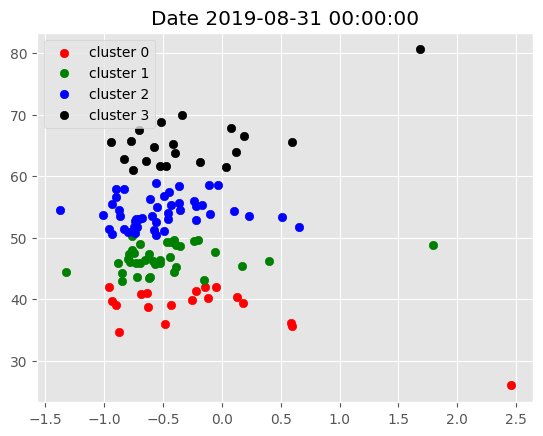

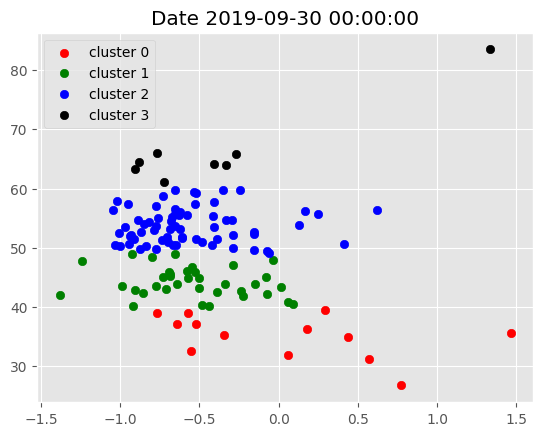

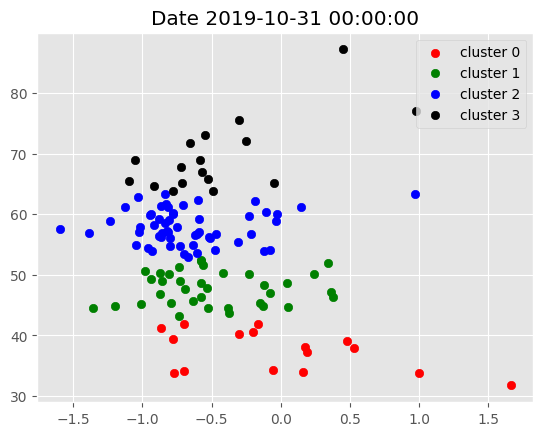

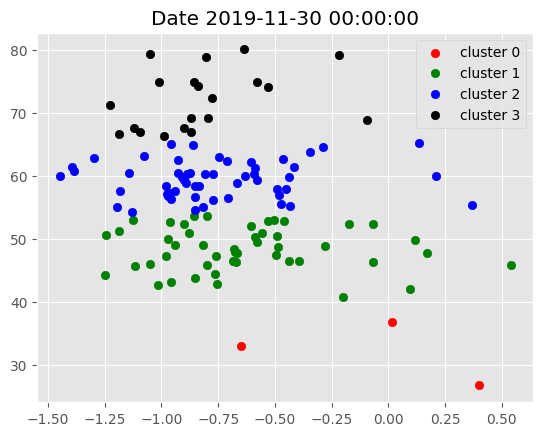

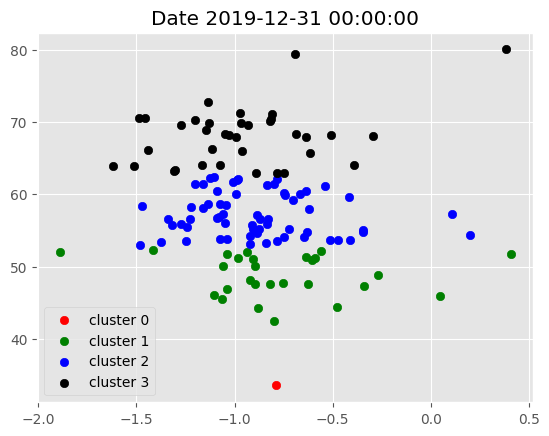

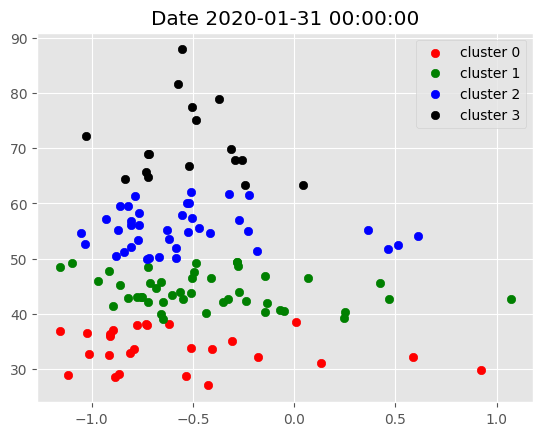

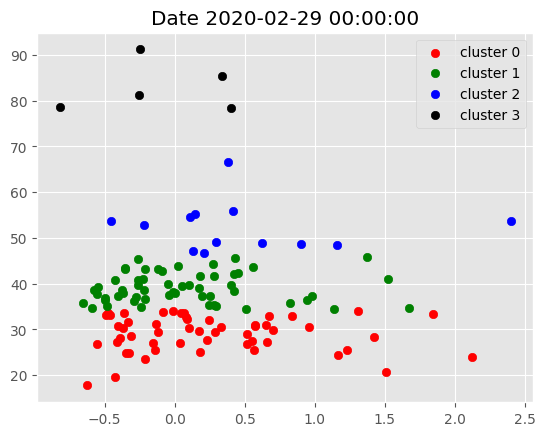

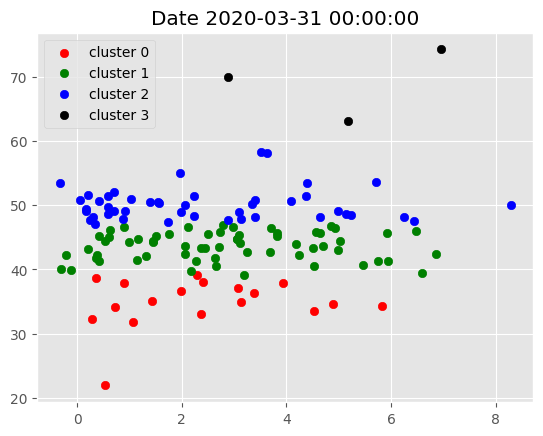

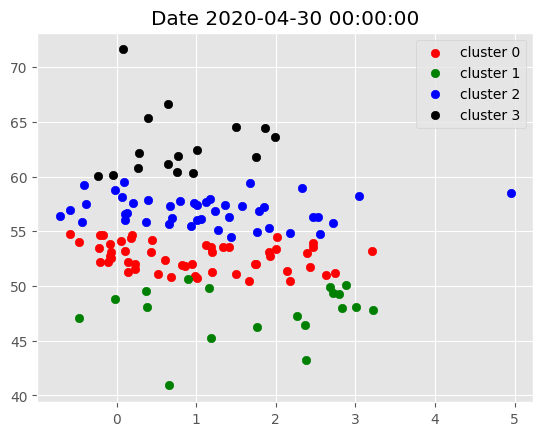

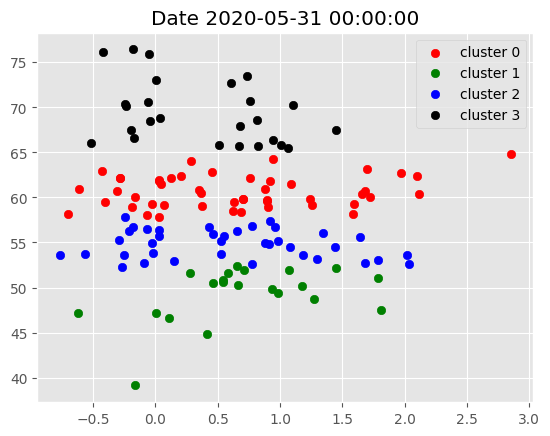

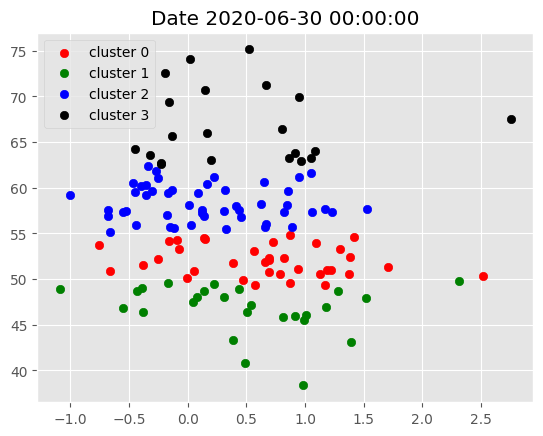

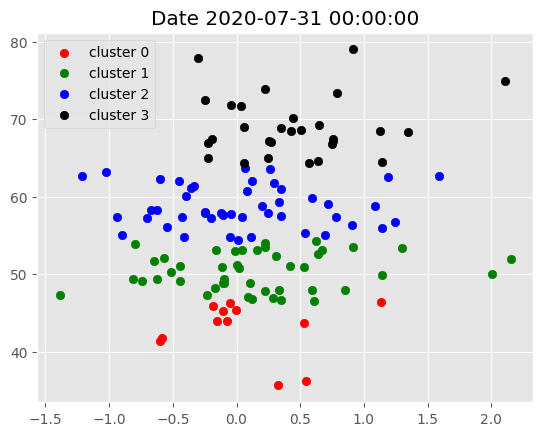

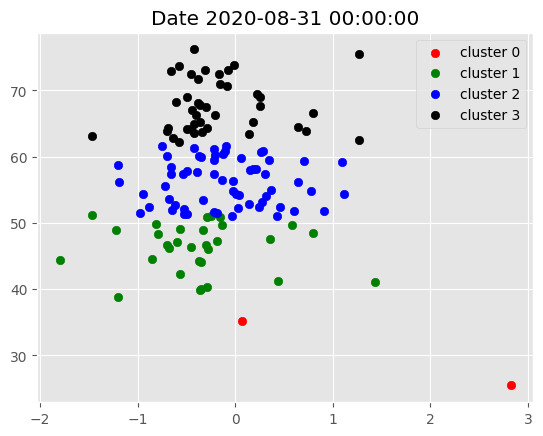

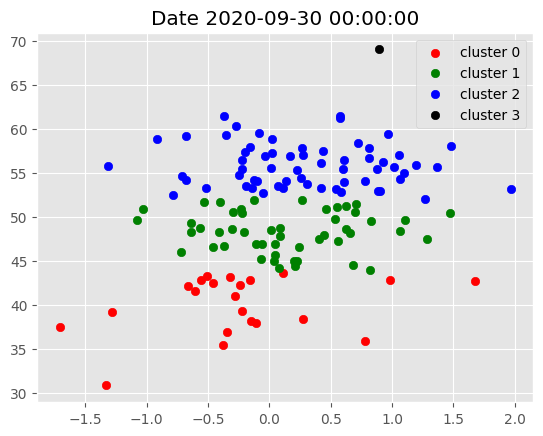

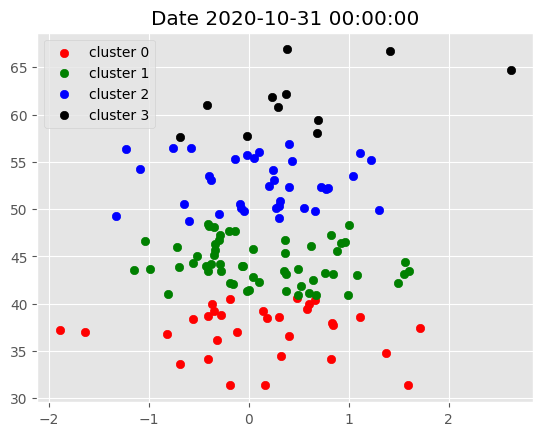

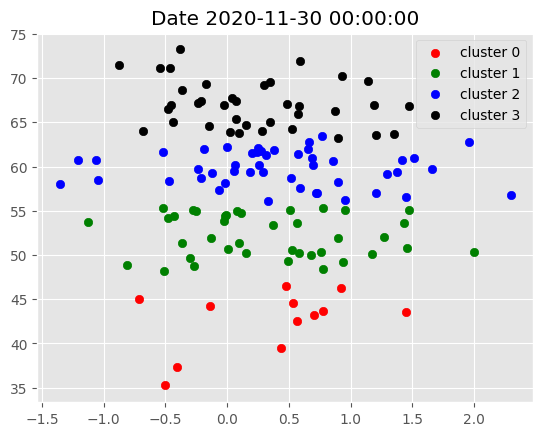

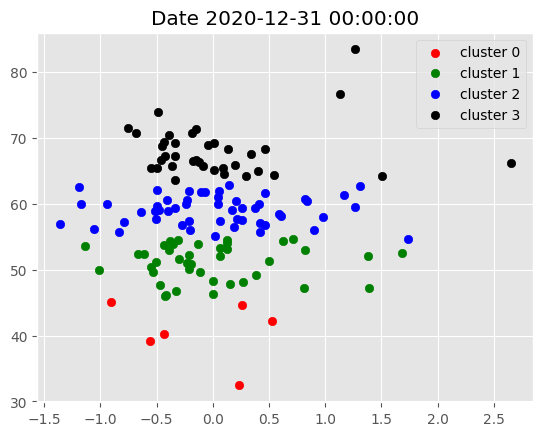

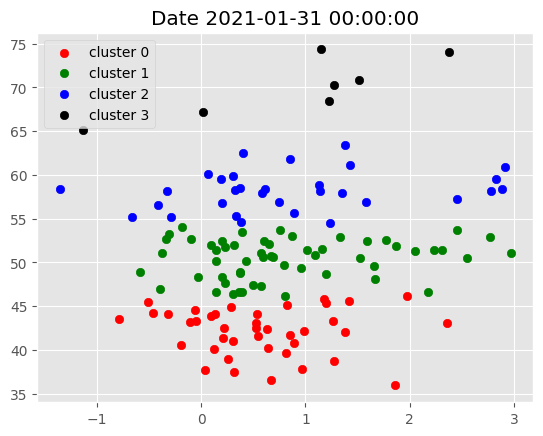

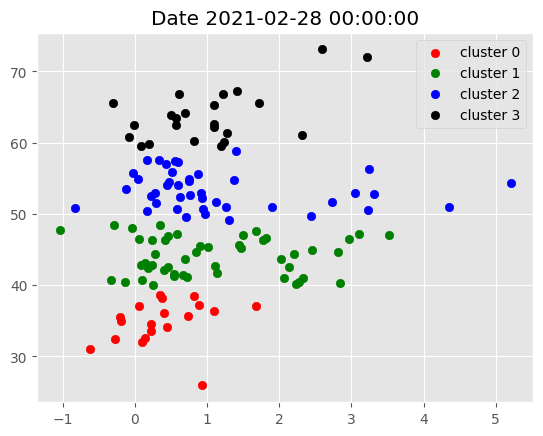

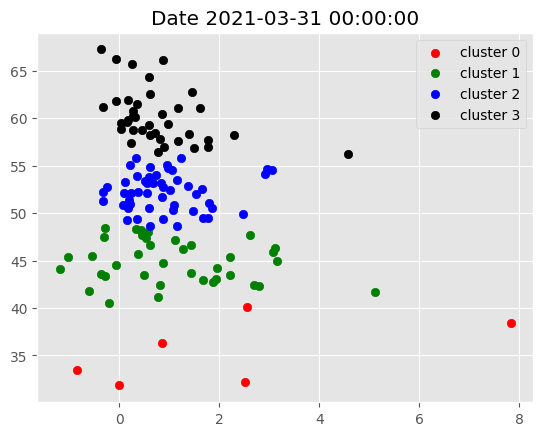

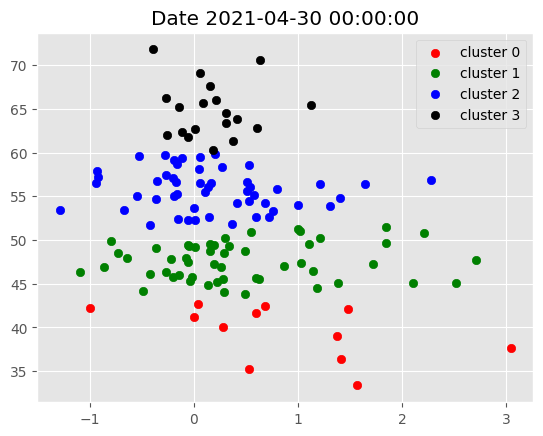

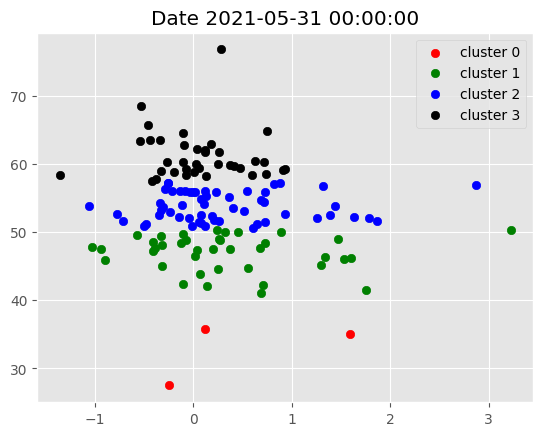

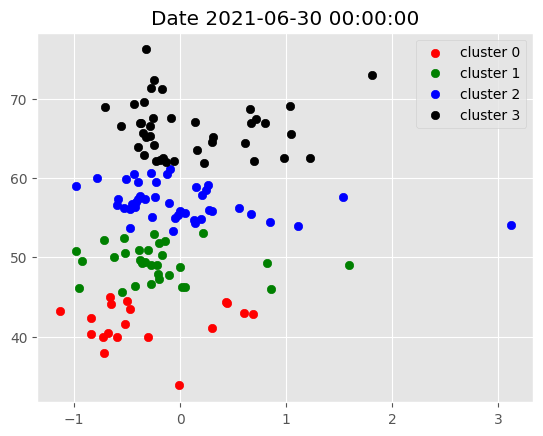

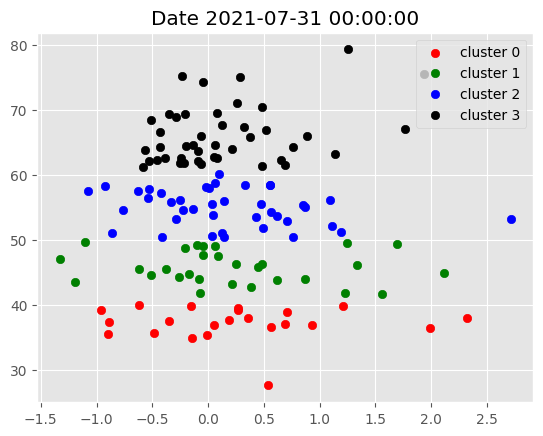

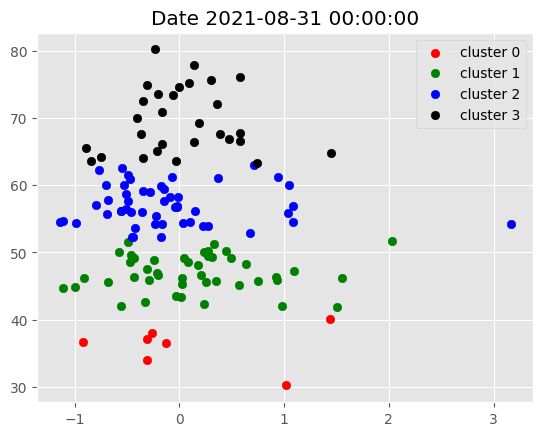

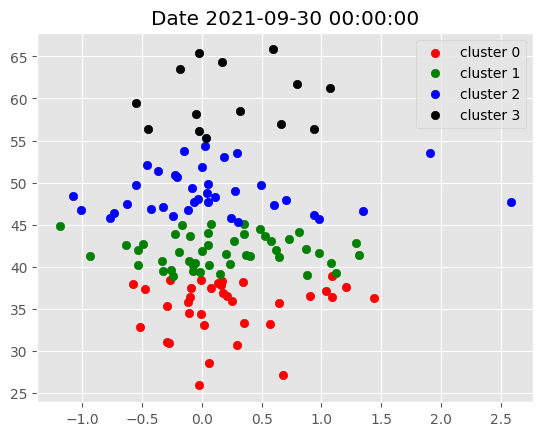

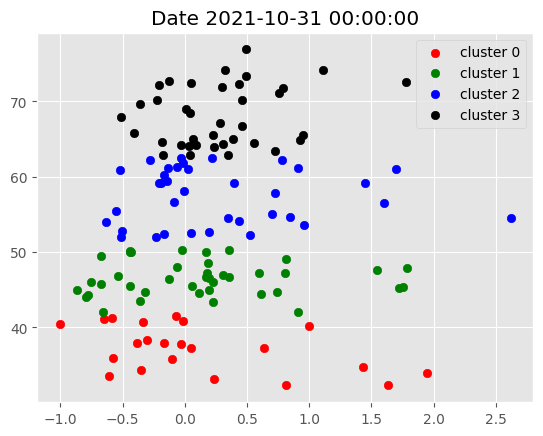

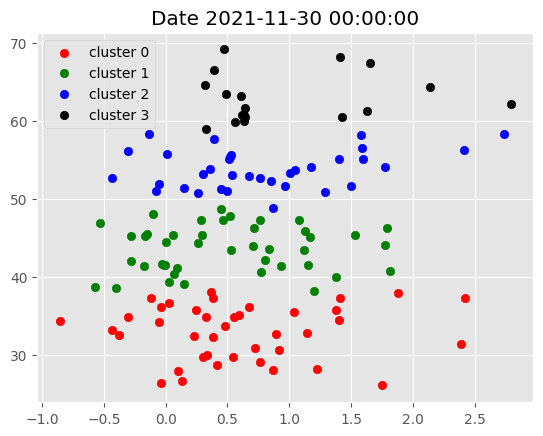

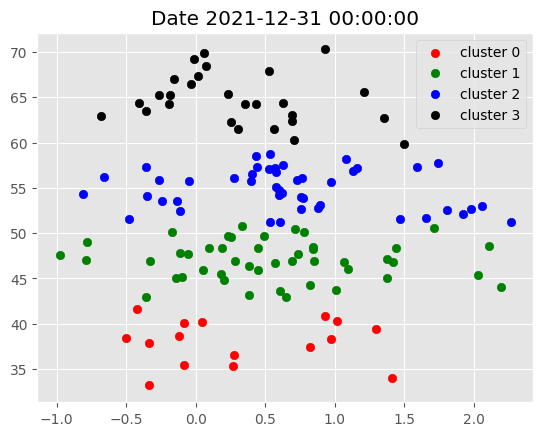

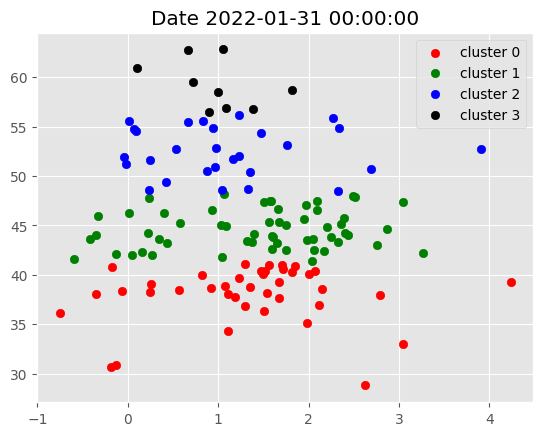

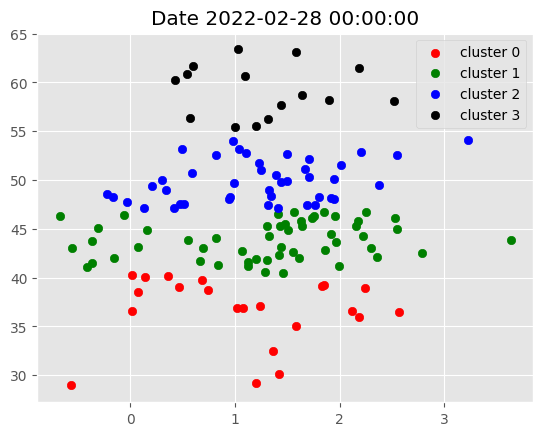

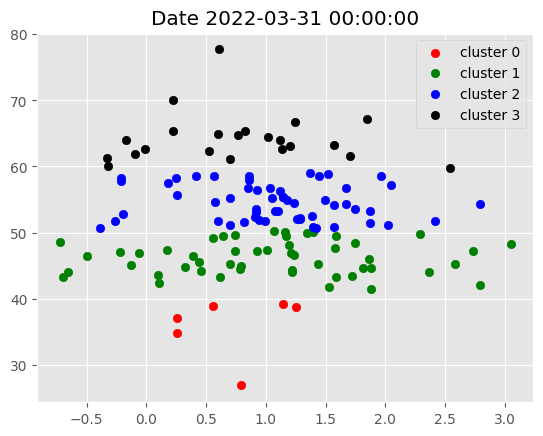

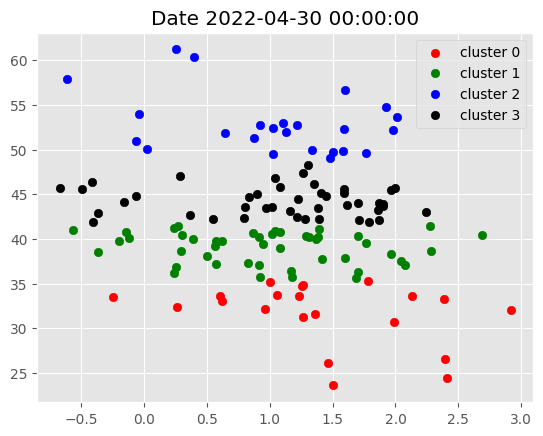

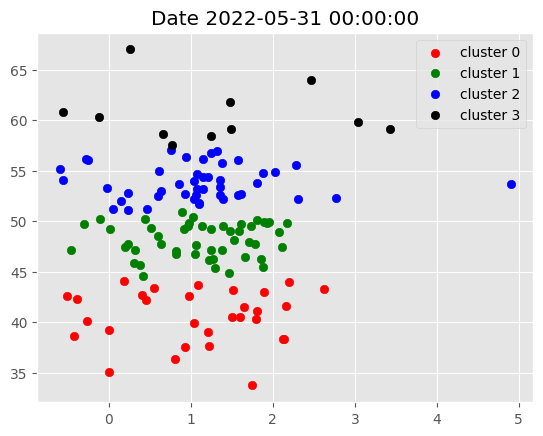

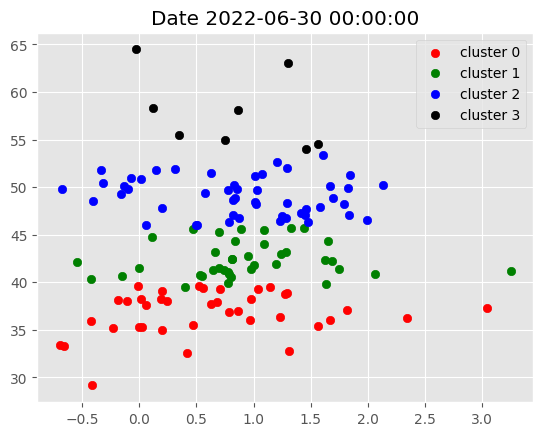

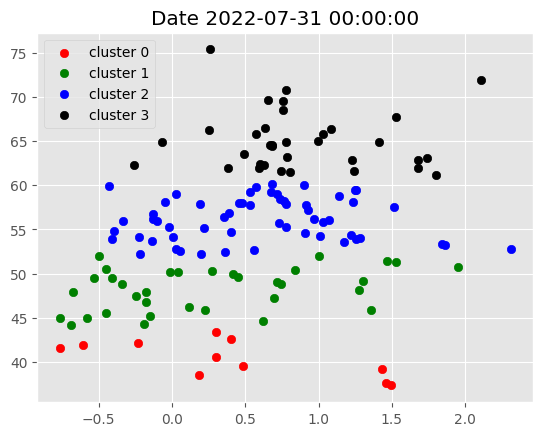

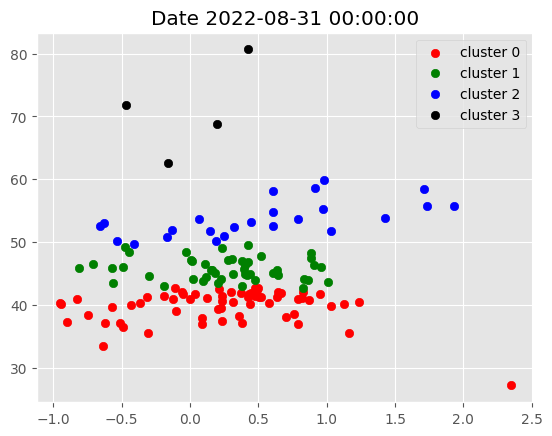

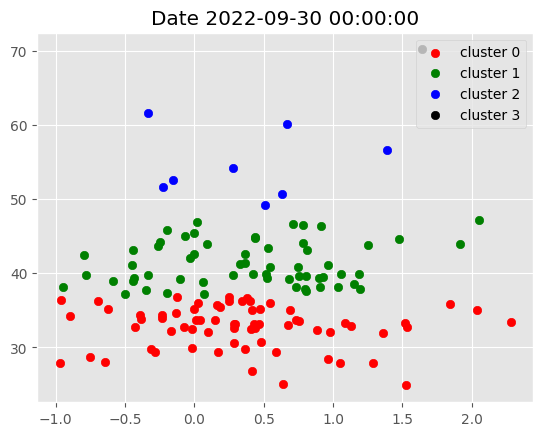

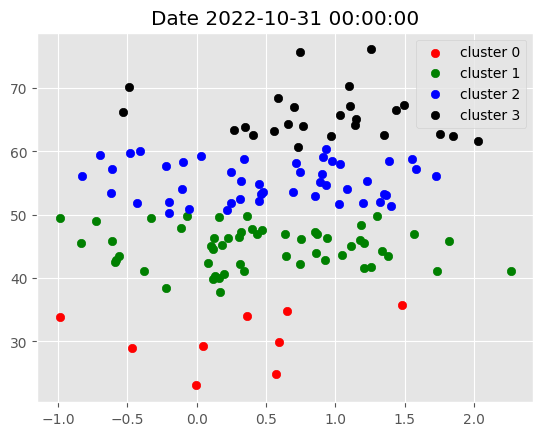

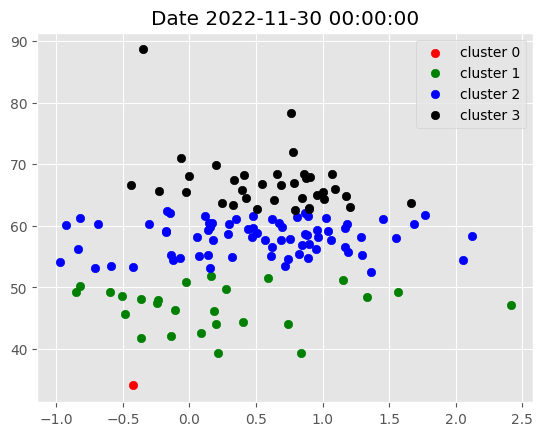

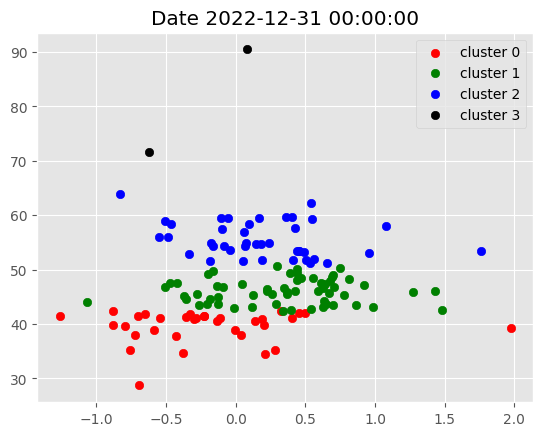

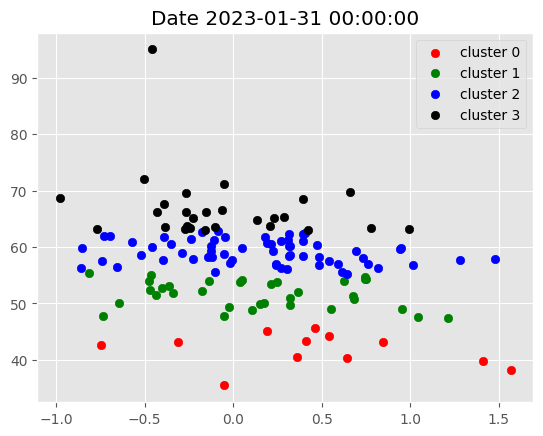

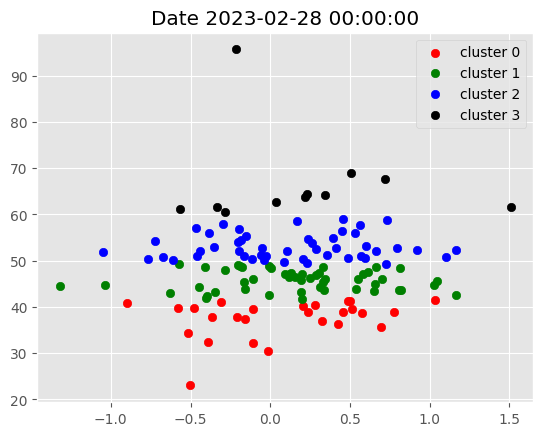

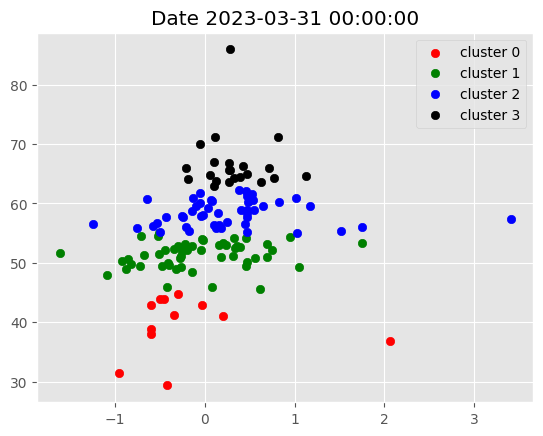

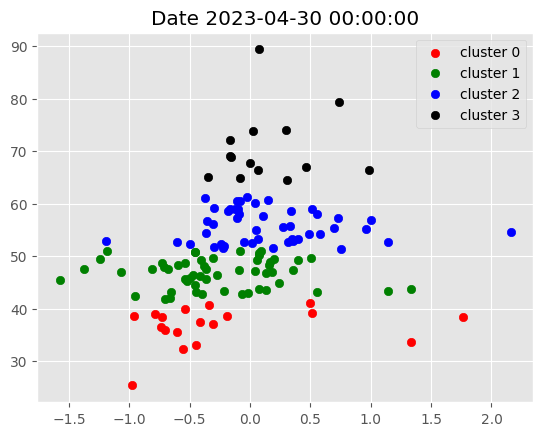

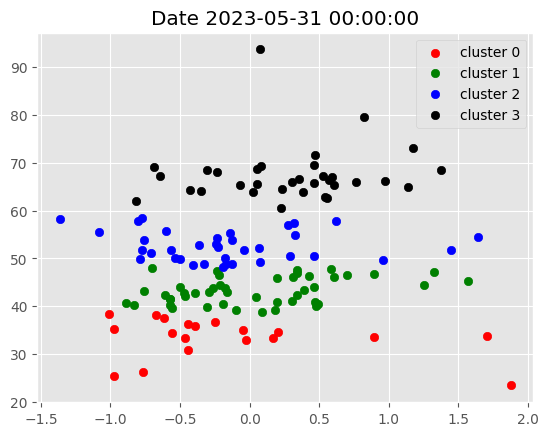

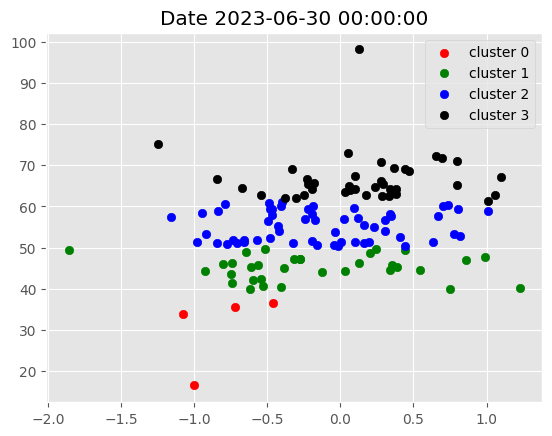

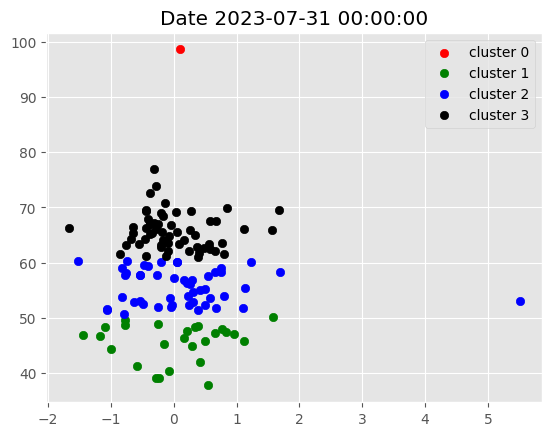

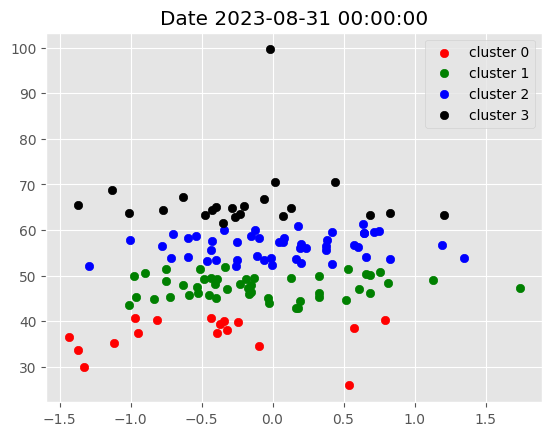

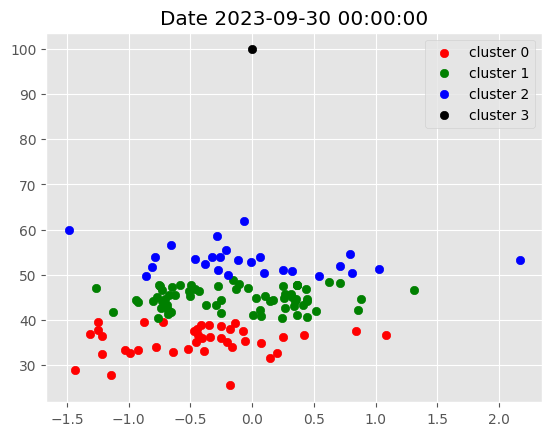

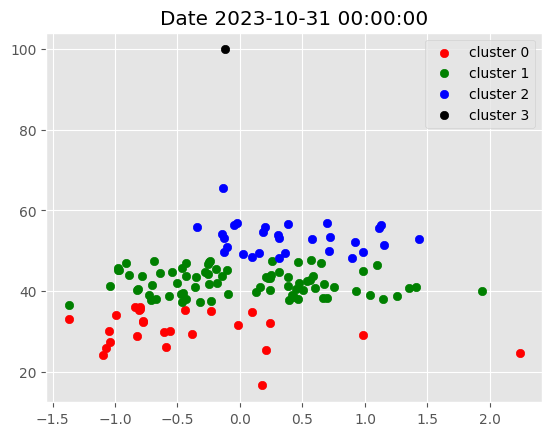

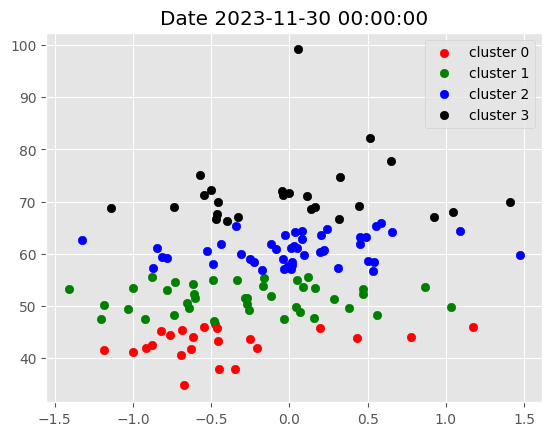

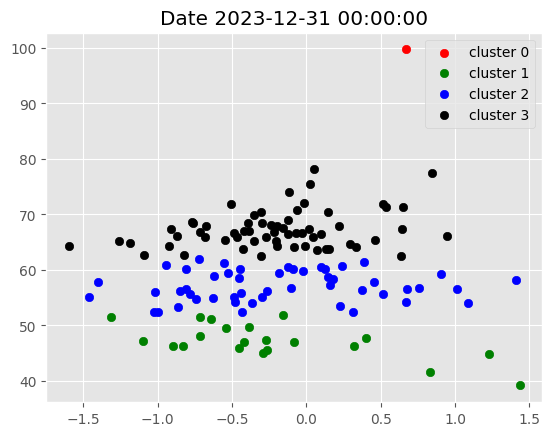

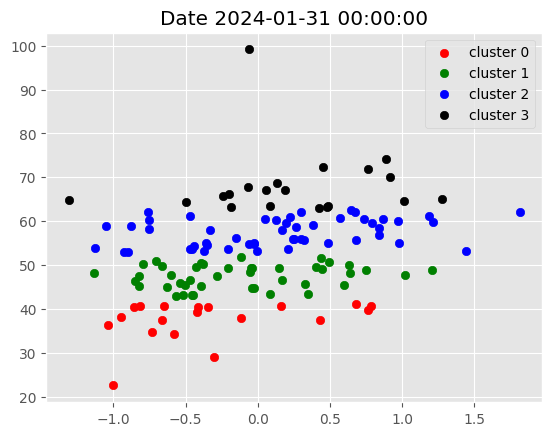

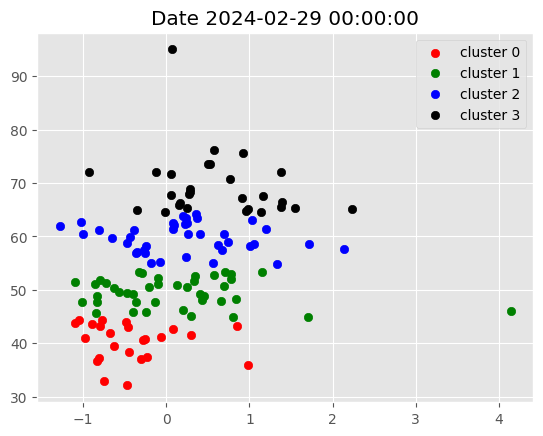

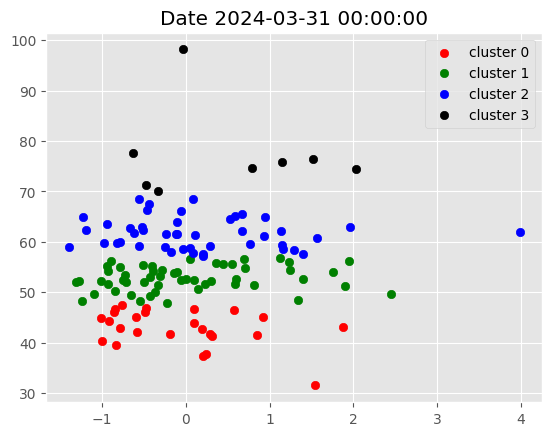

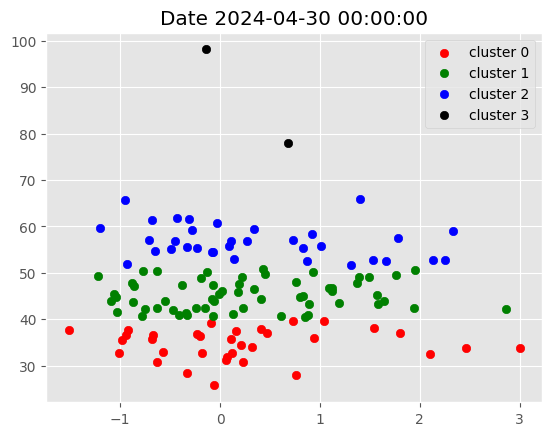

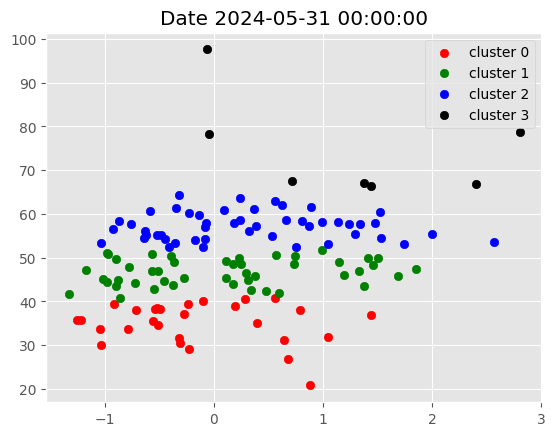

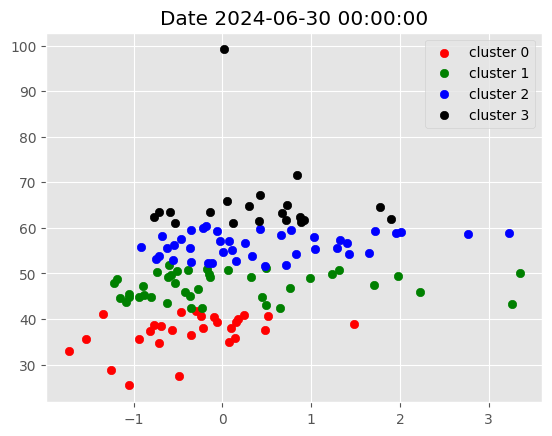

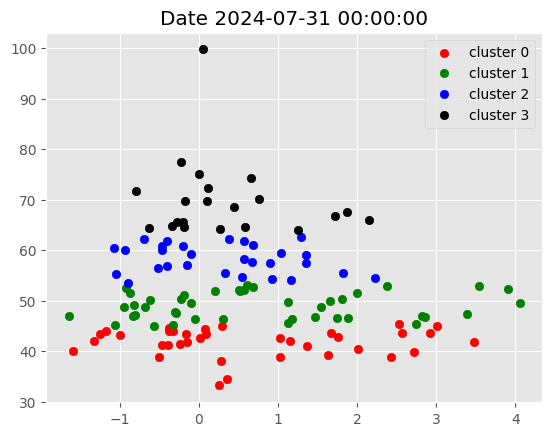

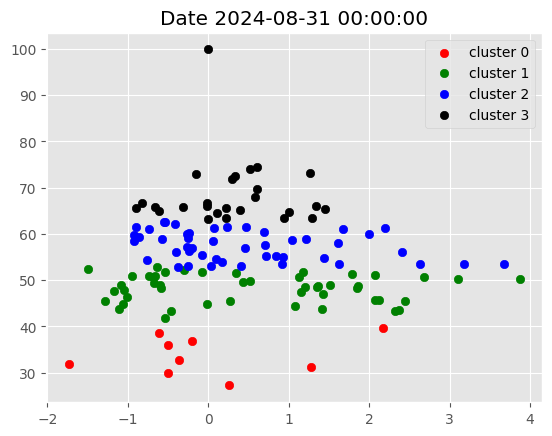

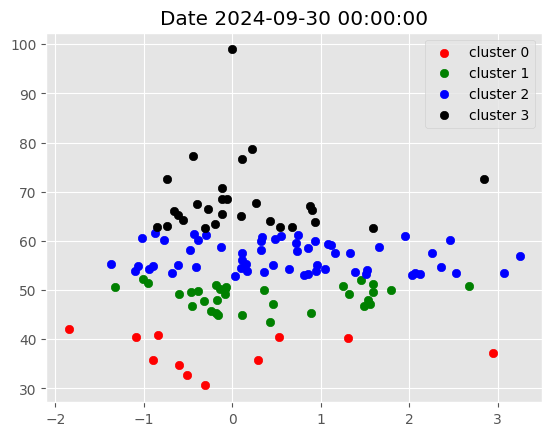

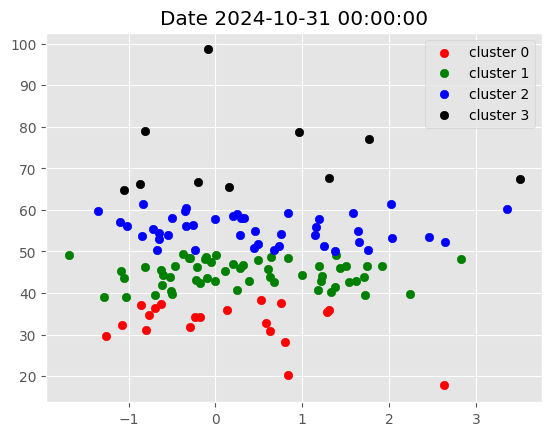

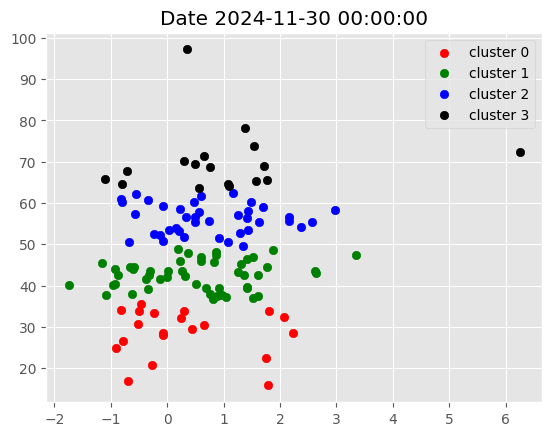

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [19]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

# convert fixed_dates to a pandas DataFrame
# Identify the last key in the dictionary
last_key = list(fixed_dates.keys())[-1]

# Extract the data associated with the last key
last_column_data = fixed_dates[last_key]

# Create a pandas DataFrame from the extracted data
watchlist = pd.DataFrame({last_key: last_column_data})
watchlist.columns.values[0] = 'Symbol'
watchlist['Exchange'] = 'NASDAQ'
watchlist['Type'] = 'Stock'

watchlist.to_csv('watchlist.csv', index=False)


# Display the DataFrame
print(watchlist)



   Symbol Exchange   Type
0     AAL   NASDAQ  Stock
1    BKNG   NASDAQ  Stock
2     BKR   NASDAQ  Stock
3    EXPE   NASDAQ  Stock
4    FAST   NASDAQ  Stock
5    FITB   NASDAQ  Stock
6    FTNT   NASDAQ  Stock
7    INTU   NASDAQ  Stock
8     MAR   NASDAQ  Stock
9    MSTR   NASDAQ  Stock
10   NFLX   NASDAQ  Stock
11    SHV   NASDAQ  Stock
12   TEAM   NASDAQ  Stock
13   TMUS   NASDAQ  Stock
14    UAL   NASDAQ  Stock
15   DOCU   NASDAQ  Stock
16     ZM   NASDAQ  Stock


In [20]:
# Step 1: Extract the last entry
# Get the last key based on maximum date
last_date = max(fixed_dates.keys())
last_date_stocks = fixed_dates[last_date]

# Step 2: Copy the values to a list (already in list form, directly use it)
stocks_to_save = last_date_stocks

# Step 3: Save the list to a CSV file
csv_filename = 'stocks_list.csv'
with open(csv_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Stocks'])  # Writing a header, optional
    for stock in stocks_to_save:
        writer.writerow([stock])  # Each stock in its own row

print(f"Data from the last date {last_date} has been saved to {csv_filename}.")


Data from the last date 2024-12-01 has been saved to stocks_list.csv.


### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Price       Adj Close                                                  \
Ticker            AAL        ACWI         ADI         ADP        ADSK   
Date                                                                    
2018-01-02  51.647556   67.936394   84.230858  107.592010  107.120003   
2018-01-03  51.014027   68.281815   85.275818  108.760780  109.379997   
2018-01-04  51.335667   68.757942   85.182518  109.799713  112.070000   
2018-01-05  51.316177   69.206055   85.527702  109.734772  110.839996   
2018-01-08  50.809345   69.271400   85.676994  109.400841  111.419998   
...               ...         ...         ...         ...         ...   
2024-11-11  14.160000  121.449997  220.470001  306.779999  313.890015   
2024-11-12  13.910000  120.550003  219.550003  307.910004  309.730011   
2024-11-13  14.010000  120.309998  212.839996  307.500000  313.140015   
2024-11-14  14.260000  119.750000  212.240005  301.989990  306.649994   
2024-11-15  14.390000  118.639999  206.350006  297.640015  299.149994   

Price                                                                  ...  \
Ticker            AEP        ALGN        ALNY        AMAT         AMD  ...   
Date                                                                   ...   
2018-01-02  62.668854  224.619995  131.850006   50.392845   10.980000  ...   
2018-01-03  62.140915  231.199997  134.649994   51.285923   11.550000  ...   
2018-01-04  61.405277  233.300003  131.960007   51.580452   12.120000  ...   
2018-01-05  61.275455  241.070007  127.730003   51.874981   11.880000  ...   
2018-01-08  61.812050  248.899994  129.179993   53.129105   12.280000  ...   
...               ...         ...         ...         ...         ...  ...   
2024-11-11  94.510002  225.240005  279.820007  188.559998  147.350006  ...   
2024-11-12  92.959999  219.089996  268.950012  186.610001  143.630005  ...   
2024-11-13  93.330002  215.029999  264.600006  182.789993  139.300003  ...   
2024-11-14  93.760002  221.639999  257.910004  186.000000  138.839996  ...   
2024-11-15  96.309998  223.690002  235.559998  168.880005  134.899994  ...   

Price         Volume                                                \
Ticker           WBA       WBD     WDAY      WDC     XRAY       YY   
Date                                                                 
2018-01-02   6605000   5028200  1599600  3894000  1622300  1948200   
2018-01-03   7147300   5292900  2047900  3253300  1533300  1256000   
2018-01-04  12456000   7875900  2774000  5173100  1052400  1152000   
2018-01-05   9067200   8498800  1025400  2727400  1329000  1423200   
2018-01-08   5312500   4103800  1626600  4875300  1188500  1457200   
...              ...       ...      ...      ...      ...      ...   
2024-11-11  20371600  39896800  2077200  4453100  5277700   289900   
2024-11-12  22423500  35222400  2669400  8477000  4358800   594000   
2024-11-13  16756000  46976900  2746800  4532000  4525000   960200   
2024-11-14  19596700  33526900  1681800  3631300  3566000   535200   
2024-11-15  22134900  37873000  2035700  3501900  4192500   281300   

Price                                                  
Ticker              ZI     ZION         ZM         ZS  
Date                                                   
2018-01-02         NaN  2387100        NaN        NaN  
2018-01-03         NaN  1575700        NaN        NaN  
2018-01-04         NaN  3309200        NaN        NaN  
2018-01-05         NaN  1212200        NaN        NaN  
2018-01-08         NaN  1697700        NaN        NaN  
...                ...      ...        ...        ...  
2024-11-11   8486700.0  1438300  5447400.0  1712100.0  
2024-11-12  20477300.0   927000  3943000.0  2260900.0  
2024-11-13  36940500.0  1419800  2729000.0  2711200.0  
2024-11-14  11076800.0   952900  2906200.0  1165200.0  
2024-11-15   9945300.0  1095800  2234600.0  1346900.0  

[1731 rows x 918 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [23]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights

,Strategy Return
date,
2019-01-02,0.000740
2019-01-03,0.003058
2019-01-04,-0.003170
2019-01-07,-0.000971
2019-01-08,-0.000926
...,...
2024-11-11,0.033624
2024-11-12,-0.004699
2024-11-13,-0.010975


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [24]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2019-01-02,0.000740,0.001040
2019-01-03,0.003058,-0.024152
2019-01-04,-0.003170,0.032947
2019-01-07,-0.000971,0.007854
2019-01-08,-0.000926,0.009352
...,...,...
2024-11-11,0.033624,0.000952
2024-11-12,-0.004699,-0.003111
2024-11-13,-0.010975,0.000486
2024-11-14,-0.007229,-0.006451


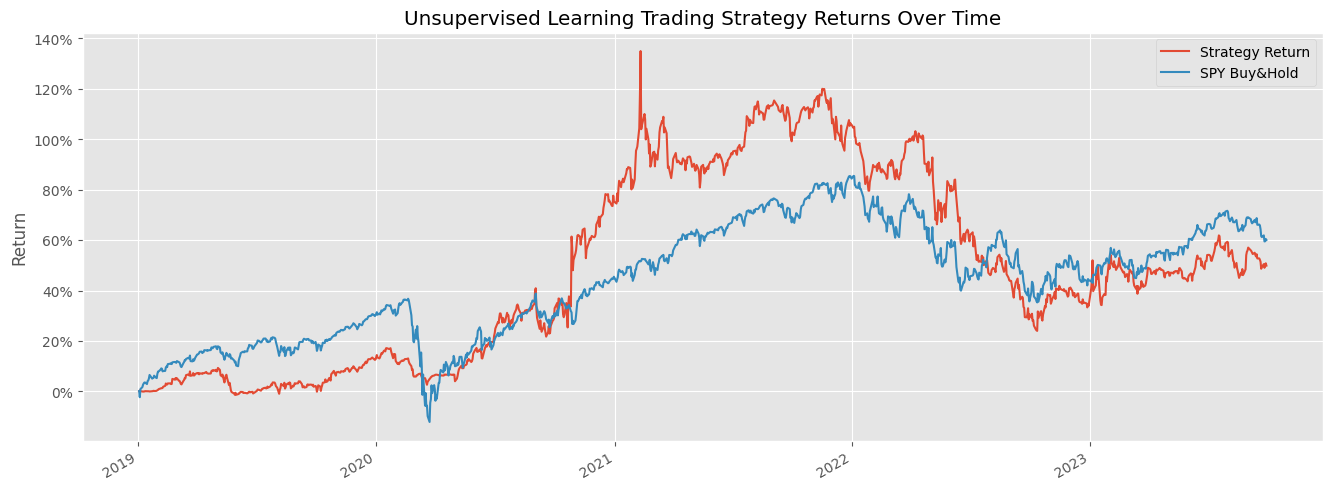

In [25]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [26]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import datetime as dt
# import yfinance as yf
# import os
# plt.style.use('ggplot')

# data_folder = 'C:/Users/user/Desktop/Python Scripts'

# sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

# sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# sentiment_df = sentiment_df.set_index(['date', 'symbol'])

# sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

# sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

# sentiment_df

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [27]:
# aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
#                     [['engagement_ratio']].mean())

# aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
#                          .transform(lambda x: x.rank(ascending=False)))

# aggragated_df

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [28]:
# filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

# filtered_df = filtered_df.reset_index(level=1)

# filtered_df.index = filtered_df.index+pd.DateOffset(1)

# filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

# filtered_df.head(20)

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [29]:
# dates = filtered_df.index.get_level_values('date').unique().tolist()

# fixed_dates = {}

# for d in dates:
    
#     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
# fixed_dates

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [30]:
# stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

# prices_df = yf.download(tickers=stocks_list,
#                         start='2021-01-01',
#                         end='2023-03-01')

## 6. Calculate Portfolio Returns with monthly rebalancing


In [31]:
# returns_df = np.log(prices_df['Adj Close']).diff().dropna()

# portfolio_df = pd.DataFrame()

# for start_date in fixed_dates.keys():
    
#     end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
#     cols = fixed_dates[start_date]
    
#     temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
#     portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
# portfolio_df

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [32]:
# qqq_df = yf.download(tickers='QQQ',
#                      start='2021-01-01',
#                      end='2023-03-01')

# qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

# portfolio_df = portfolio_df.merge(qqq_ret,
#                                   left_index=True,
#                                   right_index=True)

# portfolio_df

In [33]:
# portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

# portfolios_cumulative_return.plot(figsize=(16,6))

# plt.title('Twitter Engagement Ratio Strategy Return Over Time')

# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# plt.ylabel('Return')

# plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [34]:
# import matplotlib.pyplot as plt
# from arch import arch_model
# import pandas_ta
# import pandas as pd
# import numpy as np
# import os

# data_folder = 'C:/Users/user/Desktop/Python Scripts'

# daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

# daily_df = daily_df.drop('Unnamed: 7', axis=1)

# daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# daily_df = daily_df.set_index('Date')


# intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

# intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

# intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

# intraday_5min_df = intraday_5min_df.set_index('datetime')

# intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

# intraday_5min_df

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [35]:
# daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

# daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

# daily_df = daily_df['2020':]

# def predict_volatility(x):
    
#     best_model = arch_model(y=x,
#                             p=1,
#                             q=3).fit(update_freq=5,
#                                      disp='off')
    
#     variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

#     print(x.index[-1])
    
#     return variance_forecast

# daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

# daily_df = daily_df.dropna()

# daily_df

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [36]:
# daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

# daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

# daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
#                                          else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
#                                          axis=1)

# daily_df['signal_daily'] = daily_df['signal_daily'].shift()

# daily_df

In [37]:
# plt.style.use('ggplot')

# daily_df['signal_daily'].plot(kind='hist')

# plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [38]:
# final_df = intraday_5min_df.reset_index()\
#                             .merge(daily_df[['signal_daily']].reset_index(),
#                                    left_on='date',
#                                    right_on='Date')\
#                             .drop(['date','Date'], axis=1)\
#                             .set_index('datetime')

# final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
#                                 length=20)

# final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
#                                      length=20).iloc[:,0]

# final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
#                                      length=20).iloc[:,2]

# final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
#                                                             (x['close']>x['uband'])
#                                              else (-1 if (x['rsi']<30)&
#                                                          (x['close']<x['lband']) else np.nan),
#                                              axis=1)

# final_df['return'] = np.log(final_df['close']).diff()

# final_df

## 5. Generate the position entry and hold until the end of the day.

In [39]:
# final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
#                                         else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
#                                         axis=1)

# final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
#                                   .transform(lambda x: x.ffill())

# final_df['forward_return'] = final_df['return'].shift(-1)

# final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

# daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

In [40]:
# import matplotlib.ticker as mtick

# strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

# strategy_cumulative_return.plot(figsize=(16,6))

# plt.title('Intraday Strategy Returns')

# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# plt.ylabel('Return')

# plt.show()
                                                                            